In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from collections import Counter
import time

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import pandas as pd

data = pd.read_csv("/content/poems-100.csv")
text = " ".join(data.iloc[:,0].astype(str))
print(text[:500])

O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt wi’ the sun:
I will luve thee still, my dear,
While the sands o’ life shall run.

And fare thee well, my only Luve
And fare thee well, a while!
And I will come again, my Luve,
Tho’ it were ten thousand


**TEXT PREPROCESSING**

In [4]:
# Convert text to lowercase and extract only words
tokens = re.findall(r'\b\w+\b', text.lower())

# Create vocabulary (unique words)
vocab = sorted(set(tokens))

# Vocabulary size
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Create word to index mapping
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Create index to word mapping (for text generation)
idx2word = {idx: word for word, idx in word2idx.items()}

Vocabulary Size: 5158


**RNN USING NUMPY**

In [5]:
import numpy as np

class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):

        # Hidden layer size
        self.hidden_size = hidden_size

        # Input to Hidden weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01

        # Hidden to Hidden weights (memory connection)
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01

        # Hidden to Output weights
        self.Why = np.random.randn(output_size, hidden_size) * 0.01

        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, x, h_prev):
        # Compute new hidden state
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)

        # Compute output
        y = np.dot(self.Why, h) + self.by

        return y, h

**Create Sequences**

In [6]:
# Length of input sequence (number of previous words used)
sequence_length = 5

# Convert entire dataset into numerical form
encoded_text = [word2idx[word] for word in tokens]

inputs = []
targets = []

# Create input-target pairs
# Example:
# Input:  I love deep learning today
# Target: tomorrow
for i in range(len(encoded_text) - sequence_length):
    inputs.append(encoded_text[i:i+sequence_length])
    targets.append(encoded_text[i+sequence_length])

# Convert to PyTorch tensors
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)

**Defining One-Hot RNN Model**

In [7]:
class OneHotRNN(nn.Module):
    """
    RNN model that takes one-hot encoded input
    """

    def __init__(self, vocab_size, hidden_size):
        super(OneHotRNN, self).__init__()

        # RNN layer
        # Input size = vocab_size (because of one-hot vectors)
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)

        # Fully connected layer to predict next word
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):

        # Pass input through RNN
        out, _ = self.rnn(x)

        # Take only the last time step output
        out = out[:, -1, :]

        # Pass through fully connected layer
        out = self.fc(out)

        return out

**TRAINING**

In [8]:
# Move tensors to device
inputs = inputs.to(device)
targets = targets.to(device)

# Initialize model
onehot_model = OneHotRNN(vocab_size, hidden_size=128).to(device)

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(onehot_model.parameters(), lr=0.001)

epochs = 60
onehot_loss_list = []
start_time = time.time()   # Start timer

for epoch in range(epochs):
    total_loss = 0

    for i in range(len(inputs)):

        x = torch.nn.functional.one_hot(
            inputs[i],
            num_classes=vocab_size
        ).float().unsqueeze(0)

        y = targets[i].unsqueeze(0)

        output = onehot_model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_loss = total_loss / len(inputs)
    print(f"One-Hot Epoch {epoch+1}, Loss: {total_loss/len(inputs)}")
    onehot_loss_list.append(epoch_loss)   #Store loss here

onehot_time = time.time() - start_time   # End timer
onehot_final_loss = total_loss / len(inputs)

print("One-Hot Training Time:", onehot_time)

One-Hot Epoch 1, Loss: 7.2140814999200025
One-Hot Epoch 2, Loss: 7.112027548172831
One-Hot Epoch 3, Loss: 7.006313763951143
One-Hot Epoch 4, Loss: 6.914219296194032
One-Hot Epoch 5, Loss: 6.879509978571383
One-Hot Epoch 6, Loss: 6.882415511376493
One-Hot Epoch 7, Loss: 6.908100964312117
One-Hot Epoch 8, Loss: 6.969518037511913
One-Hot Epoch 9, Loss: 7.009086177557721
One-Hot Epoch 10, Loss: 7.080002793107839
One-Hot Epoch 11, Loss: 7.13247085133525
One-Hot Epoch 12, Loss: 7.168981827645708
One-Hot Epoch 13, Loss: 7.183395041484493
One-Hot Epoch 14, Loss: 7.202473051668988
One-Hot Epoch 15, Loss: 7.232420240691935
One-Hot Epoch 16, Loss: 7.145979164500627
One-Hot Epoch 17, Loss: 7.158532171518449
One-Hot Epoch 18, Loss: 7.078555101661252
One-Hot Epoch 19, Loss: 7.036597621076495
One-Hot Epoch 20, Loss: 6.998302207017135
One-Hot Epoch 21, Loss: 7.000255258850705
One-Hot Epoch 22, Loss: 6.970885459496675
One-Hot Epoch 23, Loss: 6.968127618087619
One-Hot Epoch 24, Loss: 6.968137228315669
O

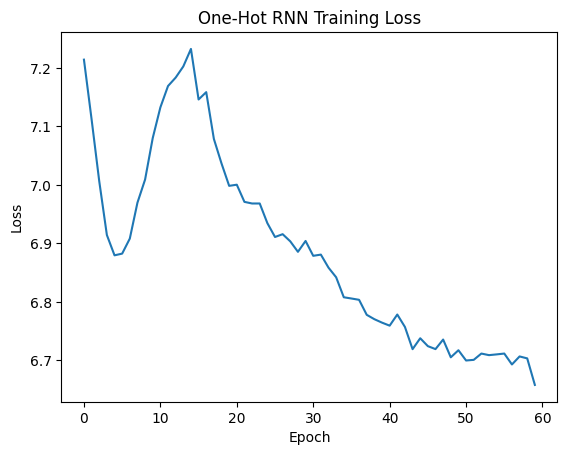

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(onehot_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("One-Hot RNN Training Loss")
plt.show()

**Model with Embedding**

In [10]:
class EmbeddingRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize embedding model
embedding_model = EmbeddingRNN(
    vocab_size,
    embed_size=100,
    hidden_size=128
).to(device)

optimizer = optim.Adam(embedding_model.parameters(), lr=0.001)



**Training (Embedding)**

In [11]:
# model2 = EmbeddingRNN(vocab_size, 100, 128).to(device)
# optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

start_time = time.time()


embedding_loss_list = []
for epoch in range(epochs):
    total_loss = 0

    for i in range(len(inputs)):

        x = inputs[i].unsqueeze(0)
        y = targets[i].unsqueeze(0)

        output = embedding_model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_loss = total_loss / len(inputs)

    # Store loss
    embedding_loss_list.append(epoch_loss)
    print(f"Embedding Epoch {epoch+1}, Loss: {total_loss/len(inputs)}")

embedding_time = time.time() - start_time
embedding_final_loss = total_loss / len(inputs)

print("Embedding Training Time:", embedding_time)

Embedding Epoch 1, Loss: 7.369352232279192
Embedding Epoch 2, Loss: 7.334227312599956
Embedding Epoch 3, Loss: 7.401490505973914
Embedding Epoch 4, Loss: 7.32328428141298
Embedding Epoch 5, Loss: 7.24214377238355
Embedding Epoch 6, Loss: 7.168222349912495
Embedding Epoch 7, Loss: 7.102972290373548
Embedding Epoch 8, Loss: 7.059238484696656
Embedding Epoch 9, Loss: 7.017243717604467
Embedding Epoch 10, Loss: 7.00411137053964
Embedding Epoch 11, Loss: 6.965998091088501
Embedding Epoch 12, Loss: 6.949731234474654
Embedding Epoch 13, Loss: 6.92794245044796
Embedding Epoch 14, Loss: 6.912822193161748
Embedding Epoch 15, Loss: 6.882848921671568
Embedding Epoch 16, Loss: 6.8665599325709845
Embedding Epoch 17, Loss: 6.848483135762443
Embedding Epoch 18, Loss: 6.829380958687893
Embedding Epoch 19, Loss: 6.813514365527046
Embedding Epoch 20, Loss: 6.798706358777869
Embedding Epoch 21, Loss: 6.778946929693066
Embedding Epoch 22, Loss: 6.766075979458277
Embedding Epoch 23, Loss: 6.756673120091928


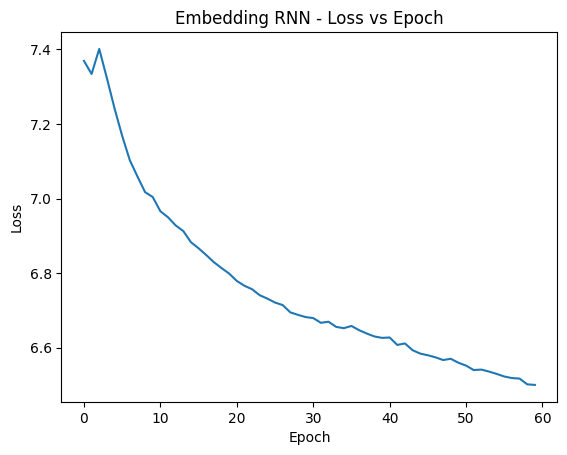

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(embedding_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Embedding RNN - Loss vs Epoch")
plt.show()

**Text Generation Function**

In [13]:
import torch.nn.functional as F

def generate_text(model, start_text, length=20, temperature=0.8):

    model.eval()
    words = start_text.lower().split()

    for _ in range(length):

        input_seq = torch.tensor(
            [word2idx[word] for word in words[-sequence_length:]]
        ).unsqueeze(0).to(device)

        output = model(input_seq)

        # Remove batch dimension
        output = output.squeeze()

        # Apply temperature scaling
        probabilities = F.softmax(output / temperature, dim=0)

        # Sample from distribution instead of argmax
        predicted_index = torch.multinomial(probabilities, 1).item()

        predicted_word = idx2word[predicted_index]

        words.append(predicted_word)

    return " ".join(words)

In [14]:
print(generate_text(embedding_model, "the sun", 20))

the sun between my other nothing a with a our his to be the all the my little be for i them
